# Baseline non-ML

Quando abbiamo a che fare con analisi dati per applicazioni reali, è sempre buona norma cominciare con soluzioni semplici ed intuitive.

Questo è utile sia per evitare di sprecare tempo con soluzioni troppo complesse e non veramente necessarie, sia per avere una baseline di performance che useremo come termine di paragone per tecniche più avanzate.

Nel nostro caso, le immagini sono caratterizzate da una scala di giallo dove i pixel più luminosi corrispondo generalmente alle cellule neuronali che vogliamo riconoscere. Un approccio molto intuitivo può quindi essere quello di fissare delle **soglie, o threshold**, sull'intensità dei pixel e **considerare tutti i pixel al di sotto come sfondo e quelli al di sopra come cellule**.

In pratica, la luminosità può variare significativamente da un'immagine all'altra, per cui fissare una soglia unica sul valore di intensità dei pixel sulla scale 0-255 risulta poco efficace.
In alternativa opteremo quindi per fissare una soglia sul quantile corrispondente della distribuzione di intensità di ogni immagine (**adaptive thresholding**). 
In questo modo, le cellule individuate saranno una percentuale fissa dei pixel più luminosi in ciascuna immagine, indipendentemente dal valore effettivo di intensità nella scala 0-255.

## Utils

Per implementare la nostra baseline non-ML dovremo scomporre la strategia di adaptive thresholding nei suoi componenti elementari, in modo da creare delle utils per ciascuno di questi step. In particolare, avremo bisogno di:

 - calcolare il valore puntuale (scala 0-255) corrispondente ad un determinato quantile (scala 0-1) della distribuzione di intensità di ciascuna immagine
 - binarizzare le immagini in base ai rispettivi threshold
 - ripulire le maschere risultanti 
     - rimuovere pixel isolati che sopravvivono al thresholding (i.e. **oggetti di piccole dimensioni**)
     - separare oggetti sovrapposti o che si toccano (**watershed**)

### Adaptive threshold

In [1]:
import numpy as np
import cv2
from scipy import ndimage
from skimage.morphology import remove_small_holes, remove_small_objects, label
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import io


def mask_post_processing(thresh_image, area_threshold=600, min_obj_size=200, max_dist=30, foot=40):

    # Find object in predicted image
    labels_pred, nlabels_pred = ndimage.label(thresh_image)
    processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
                                   in_place=False)
    processed = remove_small_objects(
        processed, min_size=min_obj_size, connectivity=1, in_place=False)
    labels_bool = processed.astype(bool)

    distance = ndimage.distance_transform_edt(processed)

    maxi = ndimage.maximum_filter(distance, size=max_dist, mode='constant')
    local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),
                                exclude_border=False,
                                labels=labels_bool)

    local_maxi = remove_small_objects(
        local_maxi, min_size=25, connectivity=1, in_place=False)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=labels_bool,
                       compactness=1, watershed_line=True)

    return(labels.astype("uint8")*255)


def make_filter_prediction(img_path, quantile):

    # cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img_gray = io.imread(img_path, as_gray=True)

    # select intensity threshold based on specified quantile
    threshold = np.quantile(img_gray.flatten(), quantile)

    # threshold the grayscale image
    thresh_image = (img_gray > threshold).astype('uint8')

    # post-processing
    thresh_image = mask_post_processing(thresh_image)

    return (thresh_image)

### Performance

Queste utils servono invece per valutare quanto bene funzioni il nostro approccio. 

In [2]:
from math import hypot


def compute_metrics(pred_mask_binary, mask, metrics, img_name):
    # extract predicted objects and counts
    pred_label, pred_count = ndimage.label(pred_mask_binary)
    pred_objs = ndimage.find_objects(pred_label)

    # compute centers of predicted objects
    pred_centers = []
    for ob in pred_objs:
        pred_centers.append(((int((ob[0].stop - ob[0].start)/2)+ob[0].start),
                             (int((ob[1].stop - ob[1].start)/2)+ob[1].start)))

    # extract target objects and counts
    targ_label, targ_count = ndimage.label(mask)
    targ_objs = ndimage.find_objects(targ_label)

    # compute centers of target objects
    targ_center = []
    for ob in targ_objs:
        targ_center.append(((int((ob[0].stop - ob[0].start)/2)+ob[0].start),
                            (int((ob[1].stop - ob[1].start)/2)+ob[1].start)))

    # associate matching objects, true positives
    tp = 0
    fp = 0
    for pred_idx, pred_obj in enumerate(pred_objs):

        min_dist = 50  # 1.5-cells distance is the maximum accepted
        TP_flag = 0

        for targ_idx, targ_obj in enumerate(targ_objs):

            dist = hypot(pred_centers[pred_idx][0]-targ_center[targ_idx][0],
                         pred_centers[pred_idx][1]-targ_center[targ_idx][1])

            if dist < min_dist:

                TP_flag = 1
                min_dist = dist
                index = targ_idx

        if TP_flag == 1:
            tp += 1
            TP_flag = 0

            targ_center.pop(index)
            targ_objs.pop(index)

    # derive false negatives and false positives
    fn = targ_count - tp
    fp = pred_count - tp

    # update metrics dataframe
    metrics.loc[img_name] = [tp, fp, fn, targ_count, pred_count]

    return(metrics)


EPS = 10**(-2)
def F1Score(metrics):
    # compute performance measure for the current quantile filter
    tot_tp_test = metrics["TP"].sum()
    tot_fp_test = metrics["FP"].sum()
    tot_fn_test = metrics["FN"].sum()
    tot_abs_diff = abs(metrics["Target_count"] - metrics["Predicted_count"])
    tot_perc_diff = (metrics["Predicted_count"] -
                     metrics["Target_count"])/(metrics["Target_count"]+EPS)
    accuracy = (tot_tp_test + EPS)/(tot_tp_test +
                                      tot_fp_test + tot_fn_test + EPS)
    precision = (tot_tp_test + EPS)/(tot_tp_test + tot_fp_test + EPS)
    recall = (tot_tp_test + EPS)/(tot_tp_test + tot_fn_test + EPS)
    F1_score = 2*precision*recall/(precision + recall)
    MAE = tot_abs_diff.mean()
    MedAE = tot_abs_diff.median()
    MPE = tot_perc_diff.mean()

    return(F1_score, MAE, MedAE, MPE, accuracy, precision, recall)

# Analisi

## Train/Validation/Test split

Come prima cosa procediamo a dividere i nostri dati in 3 sottoinsiemi. Per la nostra analisi avremo:
 - **Train set:** 170 immagini (~60%) $\longrightarrow$ utilizzato per allenare i modelli
 - **Validation set:** 85 immagini (~30%) $\longrightarrow$ utilizzato per ottimizzare gli iperparametri
 - **Test set:** 28 immagini (~10%) $\longrightarrow$ utilizzato per valutare le performance di previsione fuori campione (nuovi dati)
 
La suddivisione verrà poi salvata nel file `split_df.csv` in modo da riutilizzare gli stessi dati per ciascuna fase anche in futuro.

In [4]:
import pandas as pd
import random
from pathlib import Path
from matplotlib import pyplot as plt

IMG_PATH = Path('../fluocells_data/all_images/images')
MASK_PATH = Path('../fluocells_data/all_masks/masks')

sample_img_names = ['Mar32bS2C2R2_DMl_200x_y.png', 'Mar27bS1C2R1_LHr_200x_y.png',
                    'Mar26bS2C1R2_LHr_200x_y.png', 'Mar41S3C1R1_DMr_200x_o.png']

random.seed(42)
image_names = [p.name for p in IMG_PATH.iterdir()]

split_df = pd.DataFrame({}, columns = ['filename', 'split'])
split_df['filename'] = image_names

for split, n_imgs in zip(['train', 'valid', 'test'], [170, 85, 28]): 
    split_filenames = random.sample(image_names, n_imgs)
    split_df.loc[split_df.filename.isin(split_filenames), 'split'] = split
    
    # remove sampled filenames
    [*map(image_names.remove, split_filenames)]
    
# save split
split_df.to_csv('../fluocells_data/split_df.csv', index_label='img_id')


print(split_df.split.value_counts())
split_df

train    170
valid     85
test      28
Name: split, dtype: int64


,filename,split
0,Mar26bS2C1R2_LHl_200x_y.png,train
1,Mar26bS1C2R1_VLPAGr_200x_y.png,valid
2,Mar26bS1C1R4_VLPAGl_200x_y.png,train
3,MAR38S1C3R1_DMR_20_o.png,train
4,Mar19bS1C4R3_DMl_200x_y.png,valid
...,...,...
278,Mar21bS2C1R2_LHl_200x_y.png,valid
279,Mar26bS2C2R1_DMl_200x_y.png,test
280,Mar23bS2C1R1_LHl_200x_y.png,valid
281,Mar31bS2C1R2_VLPAGr_200x_y.png,train


## Ottimizzazione quantile




<div class="alert alert-block alert-warning">

**Nota:** sebbene non sia formalmente corretto, in questo caso utilizziamo training e validation set congiuntamente per la scelta della soglia di binarizzazione ottimale. Questo potrebbe portare ad una sovrastima delle performance, tuttavia nel nostro caso non è un grosso problema dal momento che vogliamo usare questo approccio solo come baseline.
    
</div>

In [13]:
from tqdm.auto import tqdm


def quantile_filter_prediction(quantile, trainval_path, debug=False):
    train_metrics = pd.DataFrame(
        columns=["TP", "FP", "FN", "Target_count", "Predicted_count"])
    for img_path in tqdm(trainval_path, leave=False):
        img_name = img_path.name
        mask_path = MASK_PATH / img_name

        # compute predicted mask and read original image and mask
        pred_mask_binary = make_filter_prediction(img_path, quantile)
        mask = io.imread(mask_path, as_gray=True)
        compute_metrics(pred_mask_binary, mask, train_metrics, img_name)

    print('Finished quantile:', quantile)

    summary = F1Score(train_metrics)
    output = [quantile, summary]

    if debug:
        output.append(train_metrics)

    return output

In [14]:
%%time

trainval_path = [
    IMG_PATH / fname for fname in split_df.query("split == 'train' or split == 'val'").filename]

quantiles = list(np.arange(start=0.98, stop=0.999, step=0.002))
performance_df = pd.DataFrame({}, columns=["F1_score", "MAE", "MedAE", "MPE", "accuracy", "precision", "recall"])

for q in tqdm(quantiles, leave=True):
    _, performance = quantile_filter_prediction(q, trainval_path[:])
    performance_df.loc[q] = performance
    
performance_df

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.98


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.982


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.984


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.986


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.988


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.99


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.992


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.994


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.996


  0%|          | 0/170 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.998
CPU times: user 2h 27min 27s, sys: 59.9 s, total: 2h 28min 27s
Wall time: 2h 28min 26s


,F1_score,MAE,MedAE,MPE,accuracy,precision,recall
0.980,0.475521,15.917647,14.5,229.109780,0.311924,0.322924,0.901548
0.982,0.492874,14.547059,13.0,198.724811,0.327029,0.341175,0.887483
0.984,0.515160,13.100000,12.0,173.058136,0.346946,0.364461,0.878341
0.986,0.525769,12.147059,11.0,156.867999,0.356639,0.380550,0.850212
0.988,0.541552,10.894118,10.0,137.058177,0.371321,0.405313,0.815754
0.990,0.556901,9.823529,9.0,121.364257,0.385906,0.433728,0.777779
0.992,0.565364,8.917647,8.0,96.253606,0.394082,0.465066,0.720818
0.994,0.573541,7.811765,6.0,79.867667,0.402073,0.509850,0.655417
0.996,0.558974,6.858824,4.0,61.681036,0.387900,0.568317,0.549933
0.998,0.474936,6.247059,2.0,36.778539,0.311421,0.674875,0.366390


In [15]:
q_best = performance_df.index[performance_df.F1_score.argmax()]

print(f"Il quantile ottimale è: {q_best}")

Il quantile ottimale è: 0.994


### Ispezione visiva

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


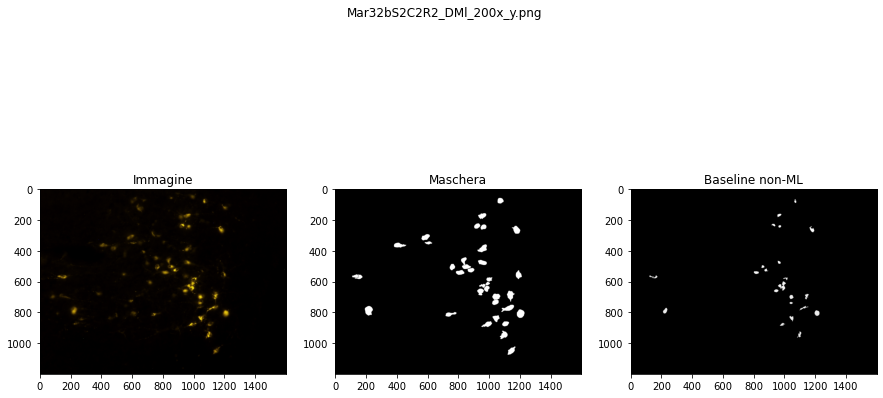

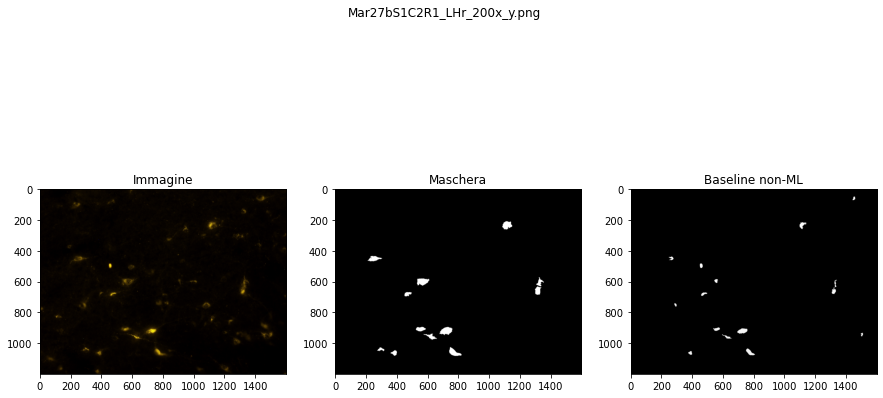

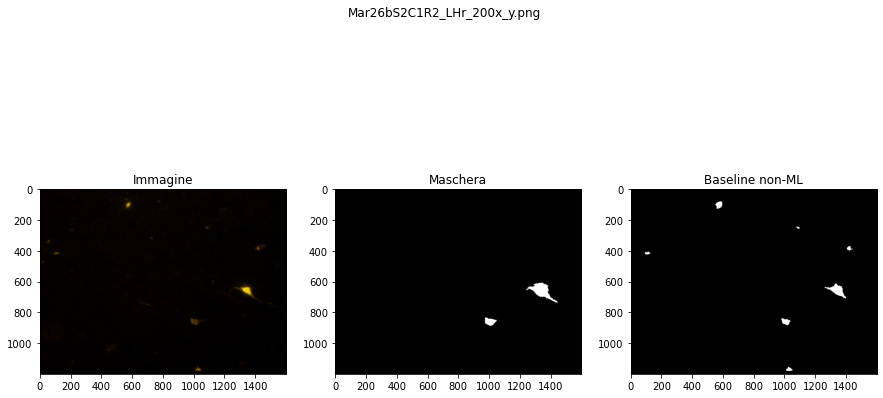

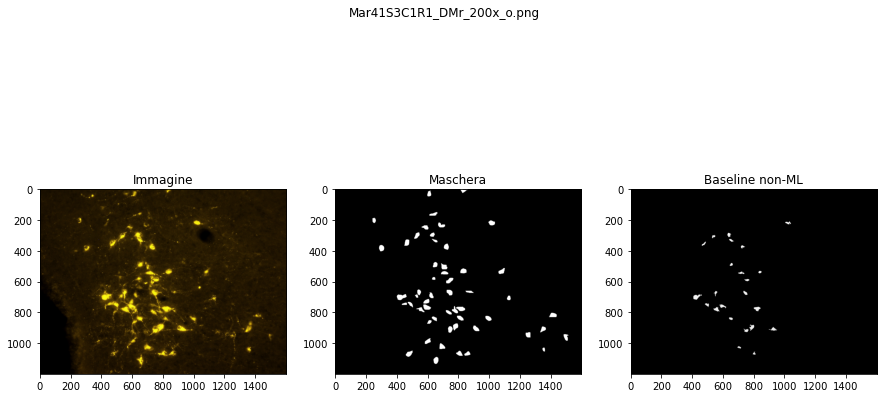

In [19]:
for img_name in sample_img_names:
    thresh_img = make_filter_prediction(IMG_PATH / img_name, q_best)
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    fig.suptitle(img_name)
    ax[0].imshow(io.imread(IMG_PATH / img_name))
    ax[0].set_title('Immagine')
    ax[1].imshow(io.imread(MASK_PATH / img_name, as_gray=True), cmap='gray')
    ax[1].set_title('Maschera')
    ax[2].imshow(thresh_img, cmap='gray')
    ax[2].set_title('Baseline non-ML')
    plt.show()

## Risultati test set 

In [16]:
%%time

test_path = [IMG_PATH /
             fname for fname in split_df.query("split == 'test'").filename]

performance_df = pd.DataFrame(
    {}, columns=["F1_score", "MAE", "MedAE", "MPE", "accuracy", "precision", "recall"])
_, performance = quantile_filter_prediction(q_best, test_path)
performance_df.loc[q_best] = performance

  0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-1-fc98549586cd>:14: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-1-fc98549586cd>:23: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


Finished quantile: 0.994
CPU times: user 1min 35s, sys: 1.2 s, total: 1min 36s
Wall time: 1min 36s


In [18]:
performance_df

,F1_score,MAE,MedAE,MPE,accuracy,precision,recall
0.994,0.540199,7.214286,7.0,145.074153,0.37005,0.411585,0.785728
